In [1]:
!pip install keras

import warnings
warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import os

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Flatten, Dropout
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Discriminator Net

In [3]:
def discriminator_builder(img_w=64, img_h=64, channels=3, width=64, p=0.4):
    
    # define inputs
    inputs = Input((img_w, img_h, channels))
    
    # convolutional layers
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    output = Dense(1, activation='sigmoid')(conv4)
    
    # model definition
    model = Model(inputs=inputs, outputs=output)
    
    return model
    

### Generator net

In [4]:
# target input image 64 * 64 * 3
def generator_builder(img_w=64, img_h=64, channels=3, z_=100, depth=128, p=0.4):
    inputs = Input((z_,))
    
    # first dense layer
    dense1 = Dense(8*8*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((8, 8, 64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # deconvolutional layer
    conv0 = UpSampling2D()(dense1)
    conv0 = Conv2DTranspose(depth // 2, kernel_size=5,
                           padding='same',
                           activation=None)(conv0)
    conv0 = BatchNormalization(momentum=0.9)(conv0)
    conv0 = Activation(activation='relu')(conv0)
    
    # deconvolutional layer
    conv1 = UpSampling2D()(conv0)
    conv1 = Conv2DTranspose(depth // 4, kernel_size=5,
                           padding='same',
                           activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    # deconvolutional layer
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(depth // 8, kernel_size=5,
                           padding='same',
                           activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    # deconvolutional layer, no up sampling here.
    conv3 = Conv2DTranspose(depth // 16, kernel_size=5,
                           padding='same',
                           activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    
    # output
    output = Conv2D(3, kernel_size=5, padding='same',
                   activation='sigmoid')(conv3)
    
    # model definition
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model
    

In [5]:
generator = generator_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
activation_1 (Activation)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 64)        0         
__________

In [6]:
discriminator = discriminator_builder()

In [7]:
discriminator.compile(loss='binary_crossentropy',
                     optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0),
                     metrics=['accuracy'])

In [8]:
def adversarial_builder(z_=100):
    
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    model.compile(loss='binary_crossentropy',
                 optimizer=RMSprop(lr=0.0004, decay=3e-8, 
                                   clipvalue=1.0),
                 metrics=['accuracy'])
    model.summary()
    return model

In [9]:
adversarial_model = adversarial_builder()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 64, 64, 3)         600883    
_________________________________________________________________
model_2 (Model)              (None, 1)                 4339329   
Total params: 4,940,212
Trainable params: 4,931,780
Non-trainable params: 8,432
_________________________________________________________________


In [10]:
loaded = np.load('cat.npz')

In [12]:
X_real = loaded['data']

In [13]:
X_real.shape

(4125, 64, 64, 3)

In [ ]:
cat_imgs_path = '/Users/Weihe/Dropbox/Datasets/dogs-cats/subset/train/cats'
cat_imgs = Path(imgs_path).iterdir()

In [ ]:
from scipy.misc import imread, imresize
X_real = np.array([imresize(imread(img), size=(64, 64, 3)) for img in cat_imgs])

In [ ]:
X_real.shape

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

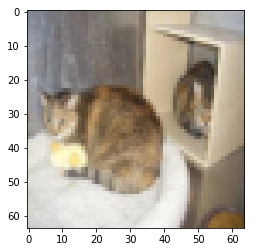

In [15]:
plt.imshow(X_real[-500])

In [16]:
# normalization
X_real = X_real / 255.0

In [ ]:
(X_real.max())

In [17]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [18]:
def train(epochs=2000, batch=128):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        real_imgs = X_real[np.random.choice(X_real.shape[0], batch, replace=False)]
        
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=(batch, 100)))
        
        x = np.concatenate((real_imgs, fake_imgs))
        y = np.ones((2*batch, 1))
        y[batch:, :] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x, y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=(batch, 100))
        y = np.ones((batch, 1))
        
        
        a_metrics.append(adversarial_model.train_on_batch(noise, y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1) % 10 == 0:
            
            print('Epoch #{}'.format(i+1))
            log_msg = '%d: [D loss:%f, acc: %f]' % (i, running_d_loss / i, running_d_acc / i)
            log_msg = '%s [A loss: %f, acc: %f]' % (log_msg, running_a_loss / i, running_a_acc / i)
            
            print(log_msg)
            
            noise = np.random.uniform(-1.0, 1.0, size=(4,100))
            
            # check generator output
            gen_imgs = generator.predict(noise)
            
            plt.figure(figsize=(5,5))
            
            for k in range(gen_imgs.shape[0]):
                plt.subplot(2, 2, k+1)
                plt.imshow(gen_imgs[k])
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
            
    return a_metrics, d_metrics


Epoch #10
9: [D loss:8.048013, acc: 0.558160] [A loss: 0.012485, acc: 1.111111]


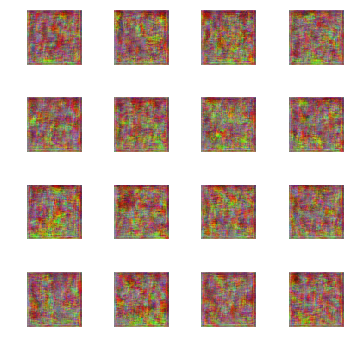

Epoch #20
19: [D loss:8.007581, acc: 0.527549] [A loss: 0.005914, acc: 1.052632]


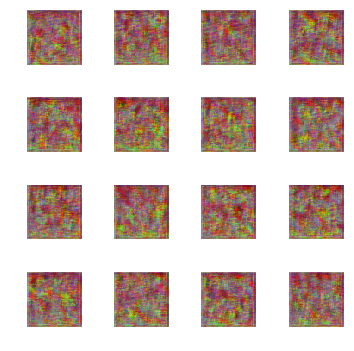

Epoch #30
29: [D loss:7.995033, acc: 0.518050] [A loss: 0.003875, acc: 1.034483]


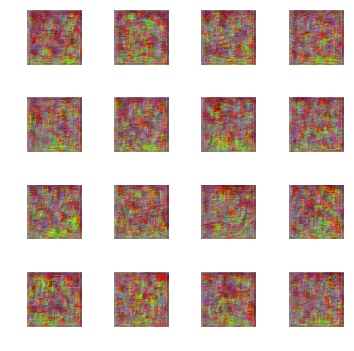

Epoch #40
39: [D loss:7.988920, acc: 0.513421] [A loss: 0.002881, acc: 1.025641]


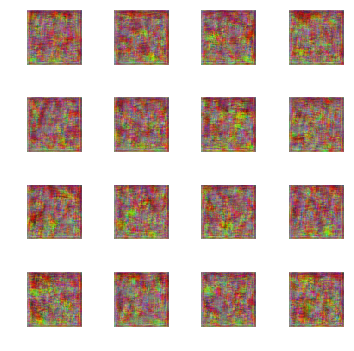

Epoch #50
49: [D loss:7.985302, acc: 0.510682] [A loss: 0.002293, acc: 1.020408]


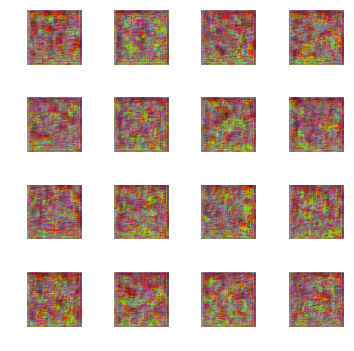

Epoch #60
59: [D loss:7.982911, acc: 0.508872] [A loss: 0.001905, acc: 1.016949]


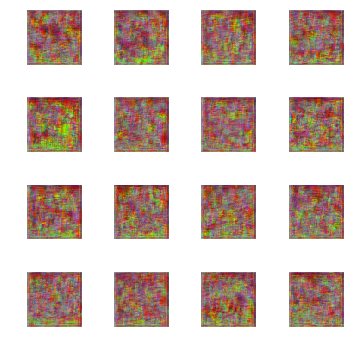

Epoch #70
69: [D loss:7.981212, acc: 0.507586] [A loss: 0.001629, acc: 1.014493]


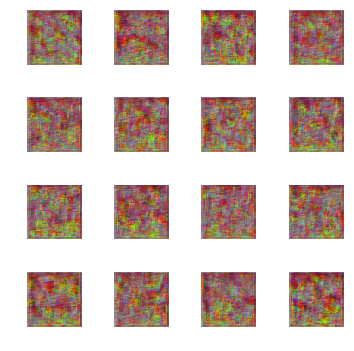

Epoch #80
79: [D loss:7.979944, acc: 0.506626] [A loss: 0.001422, acc: 1.012658]


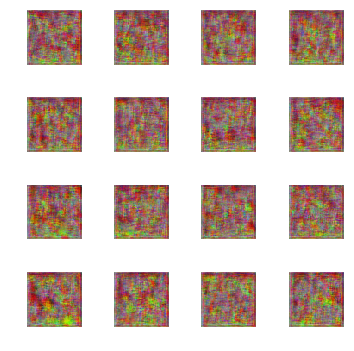

Epoch #90
89: [D loss:7.978961, acc: 0.505881] [A loss: 0.001263, acc: 1.011236]


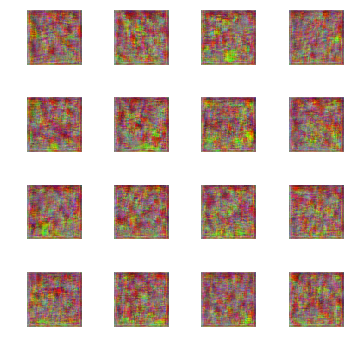

Epoch #100
99: [D loss:7.978176, acc: 0.505287] [A loss: 0.001135, acc: 1.010101]


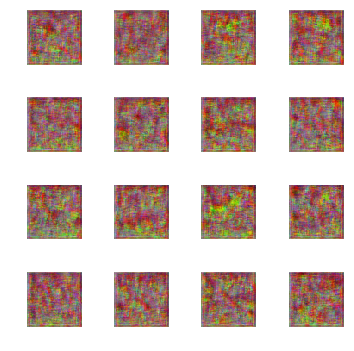

In [19]:
a_met, d_met = train(epochs=100)

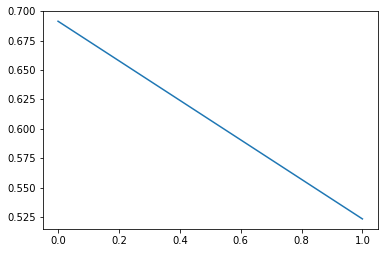

In [20]:
plt.plot(d_met[0])

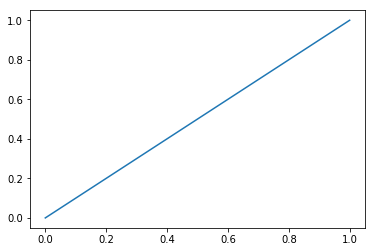

In [21]:
plt.plot(a_met[1])

In [22]:
new_cat = generator.predict(np.zeros((1, 100, )))

In [ ]:
new_cat.shape

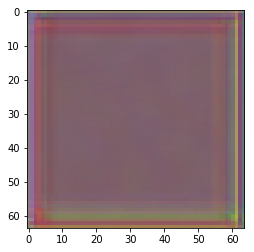

In [23]:
plt.imshow(new_cat[0])